<a href="https://colab.research.google.com/github/Misha-private/Demo-repo/blob/main/ML_2DRTMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preliminary probing

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Create a 2D grid of x and y values
def plot2d(A1, k1, l1, s1, t1,
           A2, k2, l2, s2, t2):
  x = np.linspace(0, 100, 200)
  y = np.linspace(0, 100, 200)

  [X, Y] = np.meshgrid(x, y)


  n2pi = 2*np.pi
  # Calculate the field values
  f = A1*np.cos(k1*X*n2pi+s1)*np.sin(l1*Y*n2pi+t1)+A2*np.cos(k2*X*n2pi+s2)*np.sin(l2*Y*n2pi+t2)

  fig, ax = plt.subplots(1, 1)
  ax.contourf(X, Y, f, cmap='viridis')

  t_name = f'Random 2D field'

  px = np.random.uniform(0,100,15)
  py = np.random.uniform(0,100,15)

  obs = A1*np.cos(k1*px*n2pi+s1)*np.sin(l1*py*n2pi+t1)+A2*np.cos(k2*px*n2pi+s2)*np.sin(l2*py*n2pi+t2)
  print(f"obs={obs}")

  ax.scatter(px, py, color='red', marker='o')

  ax.set_title(t_name,fontsize=14)

  ax.set_ylabel('Y')
  ax.set_xlabel('X')
  plt.show()

obs=[ 1.0116957   0.9445551  -0.70913795  0.01055338  0.24749534  2.5432348
  3.58292694  0.50151498  4.67141316 -0.2335675   0.07046868  0.05075241
  2.68921083 -1.49041752 -0.52183949]


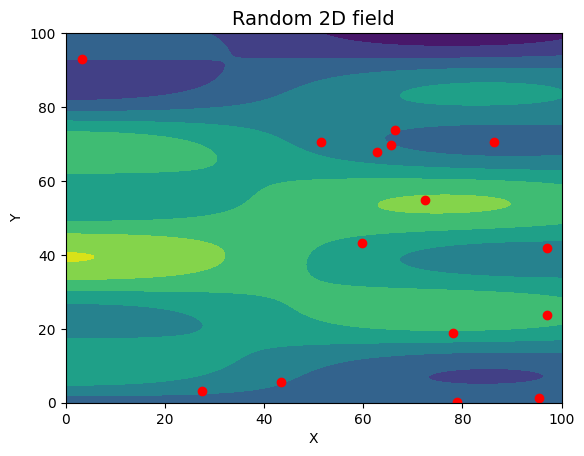

In [16]:
A1 = np.random.normal(2,0.1,1)
k1 = 0.025*np.random.randn()
l1 = 0.025*np.random.randn()
s1 = np.random.normal(0,0.1,1)
t1 = np.random.normal(0,0.1,1)

A2 = np.random.normal(4,0.1,1)
k2 = 0.005*np.random.randn()
l2 = 0.005*np.random.randn()
s2 = np.random.normal(0,0.1,1)
t2 = np.random.normal(0,0.1,1)

plot2d(A1, k1, l1, s1, t1, A2, k2, l2, s2, t2)


In [17]:
0.1*np.random.randn()

0.029395768133905837

In [18]:
import numpy as np
mu, sigma = 0, 0.1 # mean and standard deviation
s = np.random.normal(mu, sigma, 1)
print(f"s={s}")

s=[-0.07399871]


# Solution with a convolutional U-net with 2 channles on input and on at output (thanks Gemini for help)

In [19]:
# --- 0. Input modules ---
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import scipy.interpolate
import matplotlib.pyplot as plt
import random

In [20]:
# --- 1. Synthetic Data Generation (for demonstration) ---
def generate_synthetic_data(grid_size=(64,64), num_observations=100,
                            num_samples=100):
  """
  Generate synthetic H_imperfect, O_observations, ahd H_true.
  H_true = A smooth 2D field.
  H_imperfect =H_true with some added noise/imperfections.
  O_observations: Sparse observations of H_true with some noise.
  """
  data = []
  x_grid = np.linspace(0, 1, grid_size[0])
  y_grid = np.linspace(0, 1, grid_size[1])
  X_grid, Y_grid = np.meshgrid(x_grid, y_grid)

  for _ in range(num_samples):
    # Generate a "true" underlying smooth field
    amplitude1 = np.random.rand()*2 + 0.5
    freq1_x = np.random.rand()*4+1
    freq2_y = np.random.rand()*4+1
    phase1_x = np.random.rand()*2*np.pi
    phase1_y = np.random.rand()*2*np.pi

    H_true = (amplitude1 * np.sin(freq1_x * np.pi* X_grid + phase1_x) *
             np.cos(freq2_y * np.pi* Y_grid + phase1_y))

    # Add some smaller scale noise/feature for more complexity
    amplitude2 = np.random.rand()*1+ 0.1
    freq2_x = np.random.rand()*8 + 2
    freq2_y = np.random.rand()*8 + 2
    H_true += (amplitude2 * np.sin(freq2_x * np.pi* X_grid) *
               np.cos(freq2_y * np.pi* Y_grid))

    # H_imperfect: H_true with added Gaussian noise/features for more complexity
    H_imperfect = H_true + np.random.normal(0, 0.5, grid_size)
    if np.random.rand() < 0.3:
      start_x = np.random.randint(0, grid_size[0] // 2)
      start_y = np.random.randint(0, grid_size[1] // 2)
      end_x = start_x + np.random.randint(grid_size[0] // 4, grid_size[0] // 2)
      end_y = start_y + np.random.randint(grid_size[1] // 4, grid_size[1] // 2)
      H_imperfect[start_x:end_x, start_y:end_y] += np.random.normal(0, 2, (end_x-start_x, end_y-start_y))

    # O_obsdervations: Irregularly placed observations of H_true
    obs_coords = []
    obs_values =[]

    for _ in range(num_observations):
      idx_x = np.random.randint(0, grid_size[0])
      idx_y = np.random.randint(0, grid_size[1])
      obs_coords.append((x_grid[idx_x],y_grid[idx_y]))
      obs_values.append(H_true[idx_x,idx_y]+np.random.normal(0,0.2))

    # Add observation noise
    data.append({
        'H_true':H_true,
        'H_imperfect': H_imperfect,
        'O_coords':np.array(obs_coords),
        'O_values':np.array(obs_values)
        })

  return data

In [21]:
# --- 2. Interpolation Function ---
def intepolate_observarions(O_coords, O_values, grid_size=(64,64)):
  """
  Interpolations irregularly placed observations onto a regular grid.
  Using scipy.interpolate.griddata for simplicity
  """
  x_grid = np.linspace(0, 1, grid_size[0])
  y_grid = np.linspace(0, 1, grid_size[1])
  points = O_coords
  values = O_values
  grid_x, grid_y = np.meshgrid(x_grid, y_grid)

  # Use 'linear' interpolation. 'cubuc' or 'nearest' are also options.
  # fill_value can be set to 0, or the mean, or some other reasonable value fo unobserved areas
  interpolated_O = scipy.interpolate.griddata(points, values, (grid_x, grid_y), method='linear', fill_value=0)
  return interpolated_O


In [22]:
# --- 3. PyTorch Dataset ---
class FieldDataset(Dataset):
  def __init__(self, data, grid_size=(64, 64)):
    self.data = data
    self.grid_size = grid_size

  def __len__(self):
    return len(self.data)

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    sample = self.data[idx]
    H_imperfect = torch.from_numpy(sample['H_imperfect']).float().unsqueeze(0) # Add channel dim
    H_true= torch.from_numpy(sample['H_true']).float().unsqueeze(0) # Add channel dim

    # Interpolated observations for this sample
    O_interpolated = intepolate_observarions(
        sample['O_coords'], sample['O_values'], self.grid_size
        )
    O_interpolated = torch.from_numpy(O_interpolated).float().unsqueeze(0) # Add channel dim

    # Combine H_imerfect and interpolated_O as input channels
    # Input will be [H_imperfect, O_interpolated]
    input_field = torch.cat((H_imperfect, O_interpolated), dim=0)

    return input_field, H_true



In [23]:
# --- 4. Convolutional Network Architecture (U-Net Inspired) ---
class DoubleConv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.double_conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

  def forward(self, x):
    return self.double_conv(x)

class Down(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.maxpool_conv = nn.Sequential(
        nn.MaxPool2d(2),
        DoubleConv(in_channels, out_channels)
    )

  def forward(self, x):
    return self.maxpool_conv(x)

class Up(nn.Module):
  def __init__(self, in_channels, out_channels, bilinear=True):
    super().__init__()
    if bilinear:
      self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
      self.conv = DoubleConv(in_channels, out_channels)
    else:
      self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
      self.conv = DoubleConv(in_channels, out_channels) # Changed from in_channels + out_channels to in_channels

  def forward(self, x1, x2):
    x1 = self.up(x1)
    # Pad x1 to match x2's spatial dimension, if necessary
    diffY = x2.size()[2] - x1.size()[2]
    diffX = x2.size()[3] - x1.size()[3]
    x1 = nn.functional.pad(x1, [diffX // 2, diffX - diffX // 2,
                                diffY // 2, diffY - diffY // 2])
    x = torch.cat([x2, x1], dim=1) # Concaternate along channel dimensions
    return self.conv(x)

class OutConv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

  def forward(self, x):
    return self.conv(x)

class UNet(nn.Module):
  def __init__(self, n_channels_input=2, n_channels_output=1, bilinear=True):
    super(UNet, self).__init__()
    self.n_channels_input = n_channels_input
    self.n_channels_output = n_channels_output
    self.bilinear = bilinear

    self.inc = DoubleConv(n_channels_input, 64)
    self.down1 = Down(64, 128)
    self.down2 = Down(128, 256)
    self.down3 = Down(256, 512)
    self.down4 = Down(512, 1024)
    self.up1 = Up(1024 + 512, 512, bilinear) # Adjusted for skip connection
    self.up2 = Up(512 + 256, 256, bilinear) # Adjusted for skip connections
    self.up3 = Up(256 + 128, 128, bilinear) # Adjusted for skip connections
    self.up4 = Up(128 + 64, 64, bilinear) # Adjusted for skip connections
    self.outc = OutConv(64, n_channels_output)

  def forward(self, x):
    x1 = self.inc(x)
    x2 = self.down1(x1)
    x3 = self.down2(x2)
    x4 = self.down3(x3)
    x5 = self.down4(x4)
    x = self.up1(x5, x4)
    x = self.up2(x, x3)
    x = self.up3(x, x2)
    x = self.up4(x, x1)
    logits = self.outc(x)
    return logits



In [24]:
# --5. Training Loop ---
def train_model(model, train_loader, val_loader, num_epochs=50,
                learning_rate=0.001, device='cpu'):
  criterion = nn.MSELoss() # Mean Squared Error is common for regresion tasks
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)

  model.to(device)

  train_losses = []
  val_losses = []

  print(f"Training on {device}")

  for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (inputs, targets) in enumerate(train_loader):
      inputs, targets = inputs.to(device), targets.to(device)

      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      loss.backward()
      optimizer.step()

      running_loss += loss.item()*inputs.size(0)

    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
      for inputs, targets in val_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        val_running_loss += loss.item()*inputs.size(0)

      epoch_val_loss = val_running_loss / len(val_loader.dataset)
      val_losses.append(epoch_val_loss)

      print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")

  print("Training finished")
  return model, train_losses, val_losses

Using device: cuda
Generating synthetic data...
Number of training samples: 400
Number of validation samples: 100
Starting training...
Training on cuda
Epoch [1/20], Train Loss: 0.1032, Val Loss: 0.0335
Epoch [2/20], Train Loss: 0.0405, Val Loss: 0.0267
Epoch [3/20], Train Loss: 0.0417, Val Loss: 0.0262
Epoch [4/20], Train Loss: 0.0316, Val Loss: 0.0256
Epoch [5/20], Train Loss: 0.0310, Val Loss: 0.0261
Epoch [6/20], Train Loss: 0.0270, Val Loss: 0.0227
Epoch [7/20], Train Loss: 0.0309, Val Loss: 0.0199
Epoch [8/20], Train Loss: 0.0289, Val Loss: 0.0382
Epoch [9/20], Train Loss: 0.0294, Val Loss: 0.0198
Epoch [10/20], Train Loss: 0.0318, Val Loss: 0.0191
Epoch [11/20], Train Loss: 0.0266, Val Loss: 0.0212
Epoch [12/20], Train Loss: 0.0280, Val Loss: 0.0213
Epoch [13/20], Train Loss: 0.0269, Val Loss: 0.0204
Epoch [14/20], Train Loss: 0.0287, Val Loss: 0.0165
Epoch [15/20], Train Loss: 0.0242, Val Loss: 0.0180
Epoch [16/20], Train Loss: 0.0281, Val Loss: 0.0234
Epoch [17/20], Train Loss

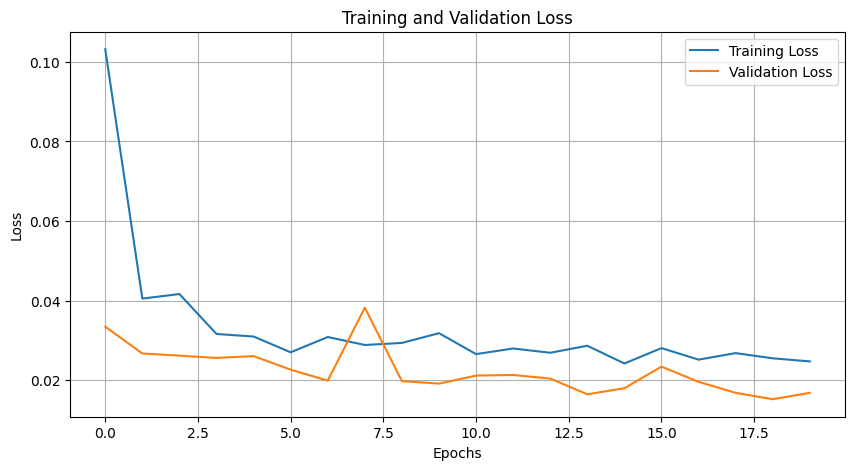


Demonstrating results on a sample for the validation set:


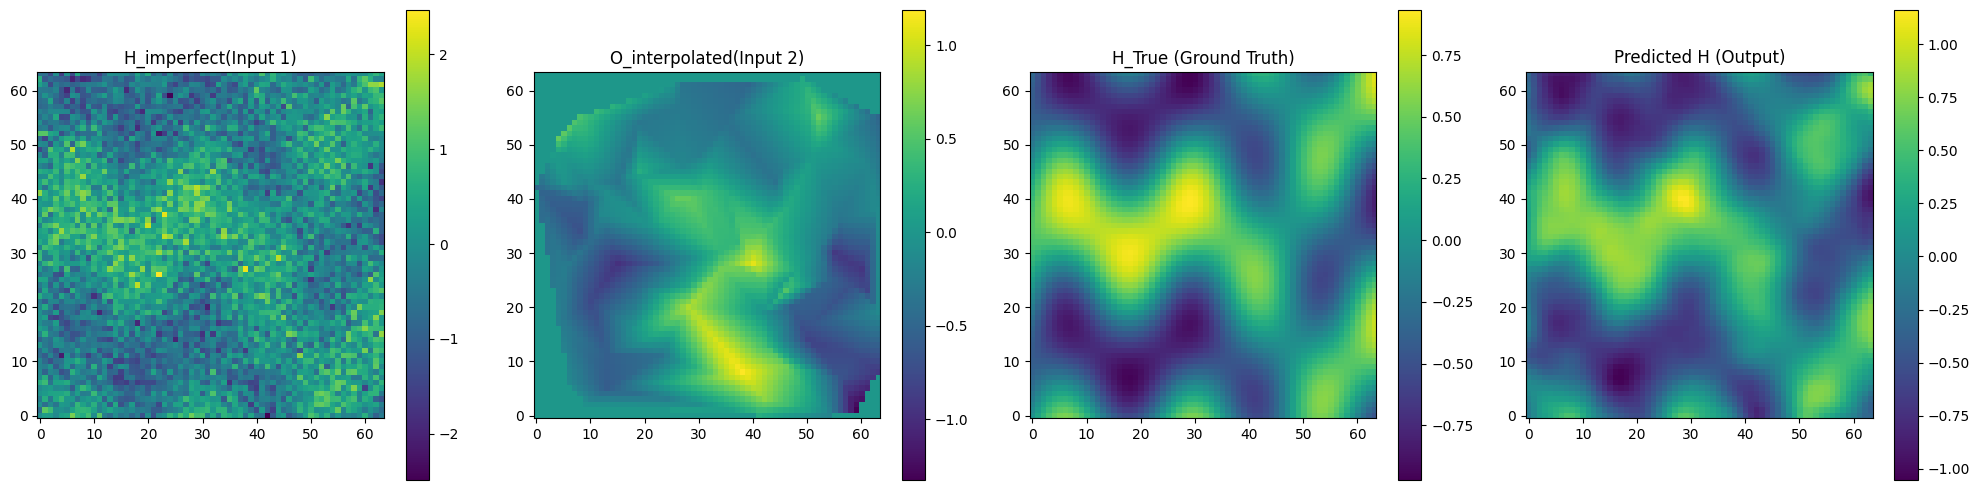

In [25]:
# --- Main Execution ---
if __name__ == "__main__":
  GRID_SIZE = (64, 64)
  NUM_SAMPLES = 500 # Total synthetic samples
  TRAIN_RATIO = 0.8
  BATCH_SIZE = 8
  NUM_EPOCHS = 20 # Reduced for quicker demonstration
  LEARNING_RATE = 0.001

  # Check for GPU
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  print(f"Using device: {device}")

  print("Generating synthetic data...")
  all_data = generate_synthetic_data(grid_size=GRID_SIZE, num_samples=NUM_SAMPLES)
  random.shuffle(all_data) # Shuffle the data
  train_size = int(TRAIN_RATIO * NUM_SAMPLES)
  train_data = all_data[:train_size]
  val_data = all_data[train_size:]

  print(f"Number of training samples: {len(train_data)}")
  print(f"Number of validation samples: {len(val_data)}")

  train_dataset = FieldDataset(train_data, grid_size=GRID_SIZE)
  val_dataset = FieldDataset(val_data, grid_size=GRID_SIZE)

  train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
  val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

  model = UNet(n_channels_input=2, n_channels_output=1) # Input has two channels, H_imperfect, O_interpolated

  print("Starting training...")
  trained_model, train_losses, val_losses = train_model(model, train_loader, val_loader,
                                                        num_epochs=NUM_EPOCHS,
                                                        learning_rate=LEARNING_RATE,
                                                        device=device)

  # Plotting training and validation loss
  plt.figure(figsize=(10, 5))
  plt.plot(train_losses, label='Training Loss')
  plt.plot(val_losses, label='Validation Loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)
  plt.show()

  # --- Demonstrate results on a sample ---
  print("\nDemonstrating results on a sample for the validation set:")
  trained_model.eval()
  with torch.no_grad():
    sample_input, sample_true_H = next(iter(val_loader))
    sample_input = sample_input[0:1].to(device) # Take one sample from the batch
    sample_true_H = sample_true_H[0:1].to(device)

    predicted_H = trained_model(sample_input)

    # Move to CPU for plotting
    H_imperfect_plot = sample_input[0,0].cpu().numpy()
    O_interpolated_plot = sample_input[0,1].cpu().numpy()
    H_true_plot = sample_true_H[0,0].cpu().numpy()
    predicted_H_plot = predicted_H[0,0].cpu().numpy()

    # Plotting
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    im0 = axes[0].imshow(H_imperfect_plot, cmap='viridis',origin='lower')
    axes[0].set_title('H_imperfect(Input 1)')
    fig.colorbar(im0, ax=axes[0])

    im1 = axes[1].imshow(O_interpolated_plot, cmap='viridis',origin='lower')
    axes[1].set_title('O_interpolated(Input 2)')
    fig.colorbar(im1, ax=axes[1])

    im2 = axes[2].imshow(H_true_plot, cmap='viridis',origin='lower')
    axes[2].set_title('H_True (Ground Truth)')
    fig.colorbar(im2, ax=axes[2])

    im3 = axes[3].imshow(predicted_H_plot, cmap='viridis',origin='lower')
    axes[3].set_title('Predicted H (Output)')
    fig.colorbar(im3, ax=axes[3])

    plt.tight_layout()
    plt.show()